# Lab: RNNs for Sentiment Analysis (with Attention)

### Juan Muñoz Villalón
### Mario Golbano Corzo
### Elena Amagro Azor

------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


In [ ]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
import os

from google.colab import drive
drive.mount("/content/drive") # Don't change this.


#my_path = "MLfH/1c/DL/Project_III_DL/"
my_path = "Master_Salud/DeepLearning/Project_III_DL/"
gdrive_path = "/content/drive" + "/My Drive/" + my_path
os.chdir(gdrive_path)

# To check the current path
!pwd
!ls

Mounted at /content/drive
/content/drive/My Drive/Master_Salud/DeepLearning/Project_III_DL
mario1_Student_Lab_RNNs_Sentiment_Analysis.ipynb
mario2_Student_Lab_RNNs_Sentiment_Analysis.ipynb
saved_models
Sentences.txt
Student_Lab_RNNs_Sentiment_Analysis.ipynb
STUDENT_Lab_RNNs_Sentiment_Analysis_with_Attention.ipynb


In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels_ori = []
for l in opinions:
  labels_ori.append(code_opinion(l))


df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels_ori.copy()
labels_bin = np.array(labels_bin)  # Asegurar que sea un numpy array
labels_bin[labels_bin == 2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/np.array(y_train).shape[0]



### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`.

In [ ]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]



### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.


In [ ]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [ ]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

### RNN classification with Attention

In [ ]:
from torch import nn
from torch import optim
import torch

In [ ]:
class RNNWithAttention(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size

        # LSTM layer
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)

        # Attention mechanism (two-layer MLP)
        self.attention_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        '''
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens.
        '''
        batch_size = x.size(0)


        # Compute RNN output (sequence of states for the whole input)
        r_out, _ = self.rnn(x, h0)  #shape: (batch_size, seq_len, hidden_dim)

        query = torch.stack([r_out[[d], lengths[d] - 1, :] for d in range(batch_size)]).reshape([-1, self.hidden_dim])  # Shape: (batch_size, hidden_dim)
        query_expanded = query.unsqueeze(1).expand(-1, r_out.size(1), -1)  # Shape: (batch_size, seq_len ,hidden_dim)


        attention_inputs = torch.cat((r_out, query_expanded), dim=2)  # Shape: (batch_size, seq_len, 2 * hidden_dim)
        unnormalized_weights = self.attention_mlp(attention_inputs).squeeze(2)  # Shape: (batch_size, seq_len)

        # Mask junk tokens (set their weights to -inf)
        mask = torch.arange(r_out.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)  # Shape: (batch_size, seq_len)
        unnormalized_weights[mask] = float('-inf')

        # Compute normalized attention weights (softmax)
        attention_weights = torch.softmax(unnormalized_weights, dim=1)  # Shape: (batch_size, seq_len)

        # Compute context vector (weighted sum of RNN outputs)
        context = torch.bmm(attention_weights.unsqueeze(1), r_out).squeeze(1)  # Shape: (batch_size, hidden_dim)

        # Pass through dropout and classifier
        context = self.dropout(context)
        output = self.fc1(context)
        output = self.logsoftmax(output)

        return output, attention_weights


In [ ]:
class RNNWithAttention_with_train(RNNWithAttention):

    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNNAttention_sentiment_analysis'):

        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)

        self.lr = lr # Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.batch_size = batch_size

        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):

        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():

            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            logprobs, _ = self.forward(x_input, torch.LongTensor(lengths))
            logprobs = logprobs.detach().numpy()

            if(len(Y)>0):

                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):

        '''
        Método de entrenamiento.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''

        self.print_every = print_every

        self.epochs=epochs

        # Optimization Loop

        self.num_train = len(docs_train) # Number of training points

        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches

        self.num_val = len(docs_val) # Number of validation points

        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels

        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels


        for e in range(int(self.epochs)):

            self.train() # Activate dropout

            # Random data permutation

            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings

                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data

                out, _ = self.forward(x_input, torch.LongTensor([len_train[d] for d in idx_batch]))

                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps
                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                idx = np.random.permutation(self.num_val)

                running_loss = 0.

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]

                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out , _ = self.forward(x_input, torch.LongTensor([len_val[d] for d in idx_batch]))

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)



            if(e % self.print_every == 0):

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

In [ ]:
my_RNN_Attention = RNNWithAttention_with_train(input_size=300, output_size=2, hidden_dim=20, n_layers=1, prob=0.3,batch_size=50,lr=0.0005)


my_RNN_Attention.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)


Training loss after 0 epochs: 0.49078604925985203. Validation loss: 0.3452876541349623
Training loss after 1 epochs: 0.3516847854607726. Validation loss: 0.30979348139630425
Training loss after 2 epochs: 0.3188899183926517. Validation loss: 0.2892461005184386
Training loss after 3 epochs: 0.2926973028950495. Validation loss: 0.27211236622598434
Training loss after 4 epochs: 0.2696059568695826. Validation loss: 0.25416557904746795
Training loss after 5 epochs: 0.24233863584391058. Validation loss: 0.23513969861798817
Training loss after 6 epochs: 0.20959337096508235. Validation loss: 0.21576765552163124
Training loss after 7 epochs: 0.17353672034119907. Validation loss: 0.19833271784914863
Training loss after 8 epochs: 0.15315914939935893. Validation loss: 0.19364483944243854
Training loss after 9 epochs: 0.13614777118375856. Validation loss: 0.18841106651557815
Training loss after 10 epochs: 0.12014099470760724. Validation loss: 0.18051528806487718
Training loss after 11 epochs: 0.1044

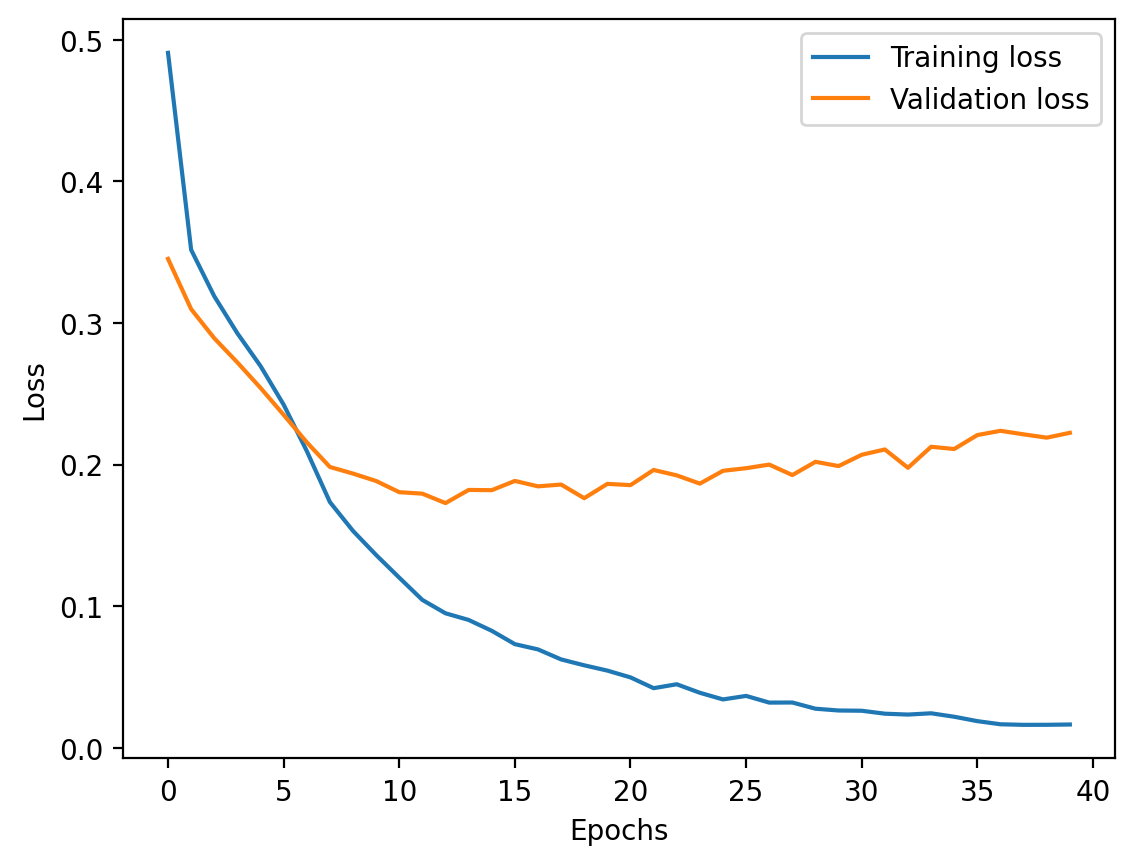

In [ ]:
# Plotting the train/val loss

fig,ax = plt.subplots(1,1)

ax.plot(my_RNN_Attention.loss_during_training,label='Training loss')
ax.plot(my_RNN_Attention.valid_loss_during_training,label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()



In [ ]:
# Recovering the best validation parameters

idx_min = np.argsort(my_RNN_Attention.valid_loss_during_training)

my_RNN_Attention.load_state_dict(torch.load(my_RNN_Attention.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<ipython-input-37-e2ad1630a62c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_RNN_Attention.load_state_dict(torch.load(my_RNN_Attention.saved_files+'_epoch_'+str(idx_m

<All keys matched successfully>

In [ ]:
logprobs,acc = my_RNN_Attention.predict_proba(docs_test,len_test, y_test)

probs = np.exp(logprobs)

print(f"The test accuracy is {acc}")

# Determinamos la clase más probable (0 o 1) para cada documento
predicted_classes = np.argmax(probs, axis=1)

class_labels = {0: "Neutral/Positive", 1: "Negative"}

# Mostramos la clase, probabilidad y etiqueta para los primeros documentos como ejemplo
print("\nProbabilidades y clases predichas para los primeros documentos:")
for i, (prob, pred_class) in enumerate(zip(probs[:5], predicted_classes[:5])):
    print(f"Document {i+1}: Class = {pred_class} ({class_labels[pred_class]}), Probabilities = {prob}")

The test accuracy is 0.9449300699300699

Probabilidades y clases predichas para los primeros documentos:
Document 1: Class = 0 (Neutral/Positive), Probabilities = [0.9917491 0.0082508]
Document 2: Class = 0 (Neutral/Positive), Probabilities = [0.7644675  0.23553248]
Document 3: Class = 0 (Neutral/Positive), Probabilities = [0.9962905  0.00370942]
Document 4: Class = 0 (Neutral/Positive), Probabilities = [0.99777716 0.00222283]
Document 5: Class = 0 (Neutral/Positive), Probabilities = [0.98939836 0.01060159]


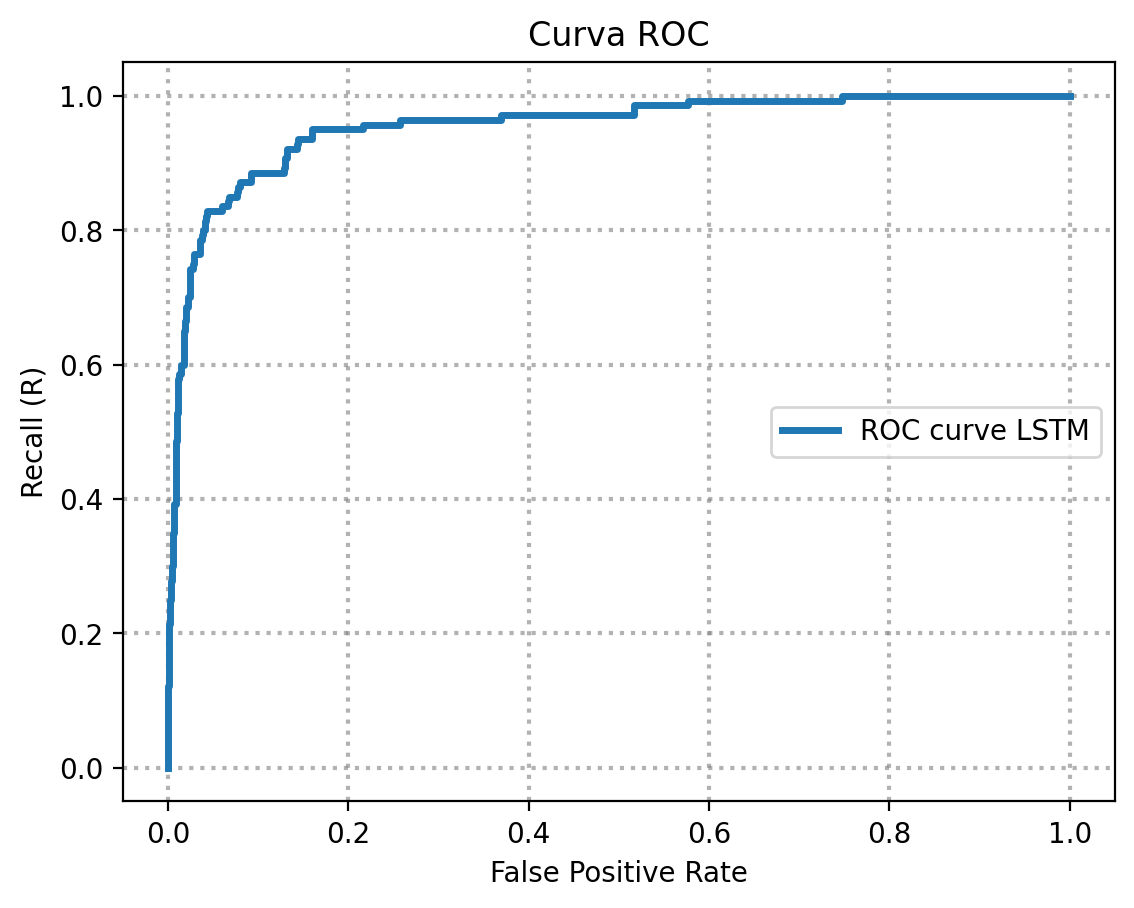

AUC ROC for LSTM is 0.954738190096756


In [ ]:
from sklearn import metrics

# Verificar si las probabilidades son válidas
if np.isnan(probs).any():
    print("Warning: NaN values found in probabilities!")
    probs = np.nan_to_num(probs)  # cambian NaN a 0

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")